In [166]:
%load_ext autoreload
%autoreload 2




        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

np.random.seed(13)
torch.manual_seed(13)

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The model will be trained with", device)



The model will be trained with cuda


In [168]:
from environments.SnowmanEnvironment_v2 import SnowmanEnvironment
map_path = './Dades/andy.txt'
save_path = './trainedModels/andy.pt'


In [169]:
map_rows=9
map_cols=9
n_actions = 4 #Modifica quan implementi gym

snowman_env = SnowmanEnvironment(map_file=map_path, 
                                 n=map_rows, m=map_cols,
                                 preprocess_mode=SnowmanEnvironment.PREPROCESS_V2,
                                 enable_step_back_optimzation=False, 
                                 enable_blocked_snowman_optimization=True,
                                 enable_snowball_number_optimization=True,
                                 enable_snowball_distances_optimization=False,
                                 enable_visited_cells_optimization=False,
                                 enable_pushable_positions_optimization=False)


n,m:  9 9
setting agent position to  4 4


In [170]:
from utils.ReplayMemory import ReplayMemory
from utils.ReplayMemory import Transition
memory = ReplayMemory(10000)

In [171]:
from neuralNests.ConvNet_v2 import DQN
policy_net = DQN(snowman_env.layers, n_actions, map_rows, map_cols).to(device)
target_net = DQN(snowman_env.layers, n_actions, map_rows, map_cols).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [172]:
from trainingAgents.SnowmanTrainingAgent_v2 import TrainingAgent

BATCH_SIZE = 254 #mida del batch del replay
GAMMA = 0.99 #factor de descompte de les recompeses futures
EPS_START = 1 #valor inicial de la epsilon per la epsilon greedy policy
EPS_END = 0.1 #valor final de la epsilon per la epsilon greedy policy
EPS_DECAY = 60000 #controla la caiguda expoencial del valor epsilon, com més alt, mes lent disminueix
TAU = 0.001 #controla cada quan s'actualitza la target network
LR = 1e-4 #Learning rate de l'optimitzador
RANDOMIZE_AGENT_POSITION_EACH_EPISODE = False
INITIAL_RANDOM_STEPS = 0

tau_mode = False

In [173]:
debug_mode = False

In [174]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
training_agent = TrainingAgent(policy_net, target_net, optimizer, memory, EPS_END, EPS_START, EPS_DECAY, GAMMA, BATCH_SIZE, INITIAL_RANDOM_STEPS, device)

MAIN TRAINING LOOP

In [175]:
episodes=200000
jugades=50
rewards = []
rewards_per_jugada = []
best_score = -100000

In [176]:
    

for episode in range(episodes):
    state, info = snowman_env.reset()
    if RANDOMIZE_AGENT_POSITION_EACH_EPISODE:
        state, info = snowman_env.randomize_agent_position()
    
    #Convertim l'estat a un tensor. Fem unsqueeze perquè la xarxa neuronal s'espera un batch de mapes, i state es un sol mapa.
    #Per tant li passem un batch de un sol mapa encapsulant en un array (o tensor)

    #Separem les capes de l'estat (mapa) en una capa per cada tipus de casella:
    #state = snowman_env.split_map_layers(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    rewards_string = []
    act_rewards = []
    nJuagades = 0
    for jugada in range(jugades):

        if RANDOMIZE_AGENT_POSITION_EACH_EPISODE and jugada % 30 == 0 and False:
            state, info = snowman_env.randomize_agent_position()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        nJuagades = nJuagades+1
        #Triem una accio segons la politica epsilon greedy
        isRandom, x, y, action = training_agent.select_action_epsilon_greedy(state, snowman_env)
        if action == None:
            break

        if debug_mode:
            print("elected: ", x, y, action)
            print("before moving")
            snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
        snowman_env.move_agent_to_position(x,y)
        if debug_mode:
            print("epsilon: ",EPS_END + (EPS_START - EPS_END) * math.exp(-1. * training_agent.steps_done / EPS_DECAY))
            print("after moving")
            snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
        next_state, reward, done, _ = snowman_env.step(action)

        act_rewards.append(reward)
        rewards_per_jugada.append(reward)
        rewards_string.append(str(reward) if isRandom else reward)

        if reward >= best_score:
            best_score = reward

        #Conevrtim el reward a un tensor i el seguent state a un tensor, aixi ho guardem al replay_memory tot en tensors:
        reward = torch.tensor([reward], device=device)
        if done:
            next_state = None
        else:
            #next_state = torch.tensor(snowman_env.split_map_layers(next_state), dtype=torch.float32, device=device).unsqueeze(0)
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        action = torch.tensor(action, dtype=torch.long, device=device).unsqueeze(0)
        training_agent.replay_memory.push(state,action, next_state, reward)

        #Anem al seguent estat
        state = next_state

        #OPTIMIZATION
        training_agent.training_step()
        


       
        if debug_mode:
            print("epsilon: ",EPS_END + (EPS_START - EPS_END) * math.exp(-1. * training_agent.steps_done / EPS_DECAY))
            print("reward", reward.item())
            snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
            #time.sleep(1)
        if done:
            break
        

    #Soft update: Quan actualitzem els pesos, actualitzem el TAU % del pes enlloc de 
    #copiar totalment el pes de cada parametre per evitar variacions massives i millorar la estabilitat:
    target_net_state_dict = training_agent.target_net.state_dict()
    policy_net_state_dict = training_agent.policy_net.state_dict()

    #per tant iterem per cada pes de la xarxa que volem actualitzar, i fem que el seu pes sigui un cert
    # percentatge (TAU) de la xarxa objectiu més el restant (1-TAU) de la seva pròpia. Si TAU és 0.01,
    #copia el 1% del pes de l'objectiu i conserva l'altre 99%
    if tau_mode:
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            training_agent.target_net.load_state_dict(target_net_state_dict)
    else:
        if episode % 20 == 0:
            training_agent.target_net.load_state_dict(training_agent.policy_net.state_dict())
        
        
    rewards.append(sum(act_rewards))
    if episode % 100 == 0:
        eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * max(0,(training_agent.steps_done-training_agent.initial_random_steps)) / EPS_DECAY)
        print("\rEpisode: {}, jugades {}, total_score: {} , score: {}, best_score: {} eps: {:.3f}    \n".format(episode, nJuagades, sum(act_rewards), rewards_string, best_score, eps), end="")
        snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)


            



C:\Users\bilal\AppData\Local\Temp\ipykernel_10660\349726988.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.long, device=device).unsqueeze(0)


Episode: 0, jugades 7, total_score: -90 , score: ['15', '-10', '15', '15', '60', '-185'], best_score: 60 eps: 1.000    
[['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '2' '#' '#']
 ['#' '#' ',' ',' '.' ',' 'q' '#' '#']
 ['#' '#' '6' ',' '.' ',' ',' '#' '#']
 ['#' '#' '.' ',' ',' ',' ',' '#' '#']
 ['#' '#' ',' ',' ',' '.' '.' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#']]


MOSTREM ELS RESULTATS (REWARDS)

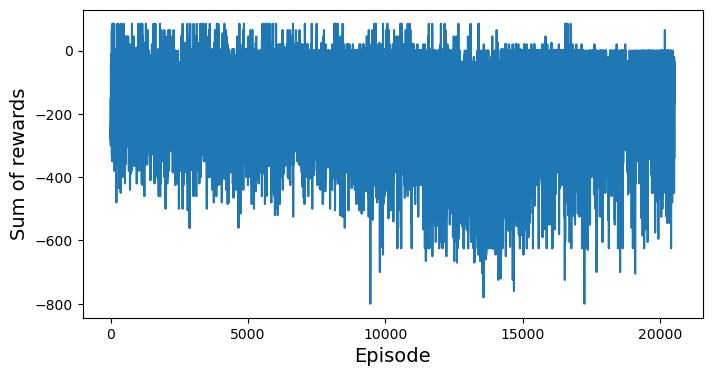

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
#save_fig("dqn_rewards_plot")
plt.show()

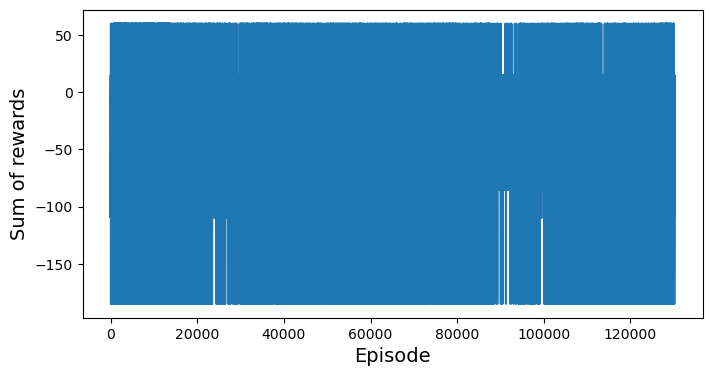

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards_per_jugada)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
#save_fig("dqn_rewards_plot")
plt.show()

El mapa final:

In [ ]:
snowman_env.show_map(SnowmanEnvironment.ENCODED_TEXT_MODE)
snowman_env.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)

Guardem el model:

In [ ]:
torch.save(training_agent.policy_net.state_dict(),save_path)

Carreguem el model i inferim:

In [ ]:

inferenceEnvironment = SnowmanEnvironment(map_path, map_rows, map_cols, preprocess_mode=SnowmanEnvironment.PREPROCESS_V3)
inferenceModel = DQN(inferenceEnvironment.layers,n_actions, map_rows, map_cols).to(device)
inferenceModel.load_state_dict(torch.load(save_path))
inferenceModel.eval()
done = False
max_steps = 100
steps = 0
while(not done and steps < max_steps):
    state = inferenceEnvironment.preprocess_map(inferenceEnvironment.map)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    valid_actions, invalid_actions = inferenceEnvironment.get_valid_actions()
    actions = inferenceModel(state)
    invalid_actions = torch.tensor(invalid_actions, device=device, dtype=torch.long)
    actions[0,invalid_actions]=-100000    
    action = actions.max(1).indices.view(1, 1)
    _, _, done, _ = inferenceEnvironment.step(action)
    inferenceEnvironment.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
    print('\n')
    time.sleep(1)



In [ ]:

from environments.SnowmanEnvironment import SnowmanEnvironment
snowman_env_test = SnowmanEnvironment(map_file='./Dades/test.txt', 
                                 n=9, m=12,
                                 preprocess_mode=SnowmanEnvironment.PREPROCESS_V2,
                                 enable_step_back_optimzation=True, 
                                 enable_blocked_snowman_optimization=True)
print(snowman_env_test.agent_position)
snowman_env_test.randomize_agent_position()
snowman_env_test.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)
print()
print(snowman_env_test.split_map_layersV2(snowman_env_test.map)[1,:])
print()
print(snowman_env_test.split_map_layersV2(snowman_env_test.map)[2,:])
#snowman_env_test.previous_agent_position = (2,6)
#snowman_env_test.agent_position = (2,6)
#a = snowman_env_test.adjust_reward(0,[5,4],[4,4])
#print(snowman_env_test.agent_position)
#print("****************************************************************")
#snowman_env_test.step(3)
#snowman_env_test.show_map(SnowmanEnvironment.DECODED_TEXT_MODE)


